## Filtering and covariances

The purpose of this notebook is to build a toy model for filtering and quantify its impact on spectra (TF) and covariances (cov correction). One could model an observed field $\tilde{X}$ as
$$
    \tilde{X}_{\ell m} = \sum_{W\in\{T,E,B\}}f_{\ell m}^{XW}W_{\ell m}
$$
which includes the effect of mode loss and leakage between fields.

This filtering affects the power spectrum as
$$
    \tilde{C}_\ell^{XY} = \sum_{WZ} \frac{1}{2\ell + 1} \sum_m f_{\ell m}^{XW}{f_{\ell m}^{YZ}}^\star {W_{\ell m}Z_{\ell m}}^\star
$$
with the following expectation value
$$
    \langle \tilde{C}_\ell^{XY} \rangle = \sum_{WZ} \frac{1}{2 \ell + 1} \sum_m \langle f_{\ell m}^{XW}{f_{\ell m}^{YZ}}^\star \rangle C_\ell^{WZ} = \sum_{WZ} T^{\rm 2pt, (XY)(WZ)}_\ell C_\ell^{WZ}
$$
where we defined
$$
    T^{\rm 2pt, (XY)(WZ)}_\ell = \frac{1}{2\ell + 1} \sum_m \langle f_{\ell m}^{XW}{f_{\ell m}^{YZ}}^\star \rangle
$$
which can be computed in this toy model example as we know analytically the quantity $f_{\ell m}$.
Maths are a bit trickier if one performs the above derivation on covariances, although it becomes relatively easy if one focuses on power loss (diagonal $f_{\ell m}$).

We start by defining some useful quantities as power spectra etc ...

In [ ]:
import camb
import healpy as hp
import numpy as np
from itertools import product

# Generate necessary inputs here
pars = camb.set_params(
    H0=67.5,
    ombh2=0.022,
    omch2=0.122,
    mnu=0.06,
    omk=0,
    tau=0.06,  
    As=2e-9,
    ns=0.965,
    halofit_version="mead",
    lmax=3000,
    r=0.01
)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(
    pars,
    CMB_unit="muK",
    raw_cl=True
)
totCL=powers["total"]

# Save all power spectra
theory_cells = {
    k: totCL[:, i]
    for i, k in enumerate(["TT", "EE", "BB", "TE"])
}
ell = np.arange(len(theory_cells["TT"]))
for k in ["TB", "EB", "BT", "BE"]:
    theory_cells[k] = np.zeros_like(ell)
theory_cells["ET"] = theory_cells["TE"]

# Generate a beam
fwhm_arcmin = 30.0
fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)
bl = hp.gauss_beam(
    fwhm=fwhm_rad,
    lmax=ell[-1])

# Generate a data map and a mask
nside = 128
aposcale = 10 #degrees

TQU_map = hp.synfast(
    [theory_cells["TT"], theory_cells["TE"], theory_cells["EE"], theory_cells["BB"]],
    nside=nside,
    fwhm=fwhm_rad
)

And some functions to define our filtering, described in `filter_alms`

In [82]:
def diag_filter(ell, ell0, pow):
    """
    This just define a smooth diagonal filter in ell space
    """
    return 1 / (1 + (ell0 / (ell+1)) ** pow)
def offdiag_filter(ell, ell0_gauss, ell0_exp, std_gauss, amp):
    """
    This function defines a different filter for off-diagonal elements
    of f_{lm}^{XW}. This correspond to filtering-induced leakage
    """
    gauss = np.exp(-(ell - ell0_gauss) ** 2 / (2 * std_gauss ** 2))
    exp = np.exp(-(ell / ell0_exp))
    tot = gauss * exp
    tot /= tot.max()
    return amp * tot
def m_filter(m, m0, m0_std):
    """
    One can also add a m-dependence to the filter
    which will be relevant to break symmetries between
    4 and 2pt transfer functions
    """
    gauss = np.exp(-(m - m0) ** 2 / (2 * m0_std ** 2))
    gauss /= gauss.max()
    return 1 - gauss

# Define a smooth filter in (l, m) space
def filter_alms(alms):
    # alms is (T, E, B)
    # We want to define a smoothing operator f_{lm}^{XW}
    # where X,W are T,E,B
    # such that the filtered alms Xf_{lm} are Xf_{lm} = f_{lm}^{XT}*alms[0] + f_{lm}^{XE}*alms[1] + f_{lm}^{XB}*alms[2]
    size = len(alms[0])
    lmax = hp.Alm().getlmax(size)
    l, m = hp.Alm.getlm(lmax=lmax)
    d_filter = diag_filter(l, 80, 2)
    od_filter = offdiag_filter(l, 40, 15, 40, 0.4)
    mfilt = m_filter(m, -10, 15)

    fl = np.zeros((3, 3, len(alms[0])))
    fl[0, 0] = d_filter * mfilt
    fl[1, 1] = d_filter * mfilt
    fl[2, 2] = d_filter * mfilt

    fl[1, 2] = od_filter * mfilt #* 0.005
    fl[2, 1] = od_filter * mfilt #* 0.005

    return fl, np.einsum("ijk,jk->ik", fl, alms)
    

Let's visualize the effect of our filtering on a map. Starting with the input Q map.

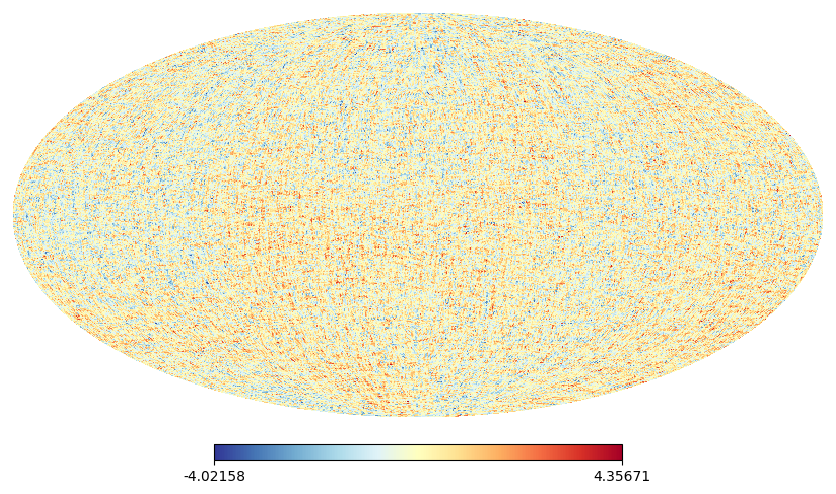

In [83]:
hp.mollview(TQU_map[1], cmap="RdYlBu_r", title="")

And the filtered Q map where we see a large scale power decrease.

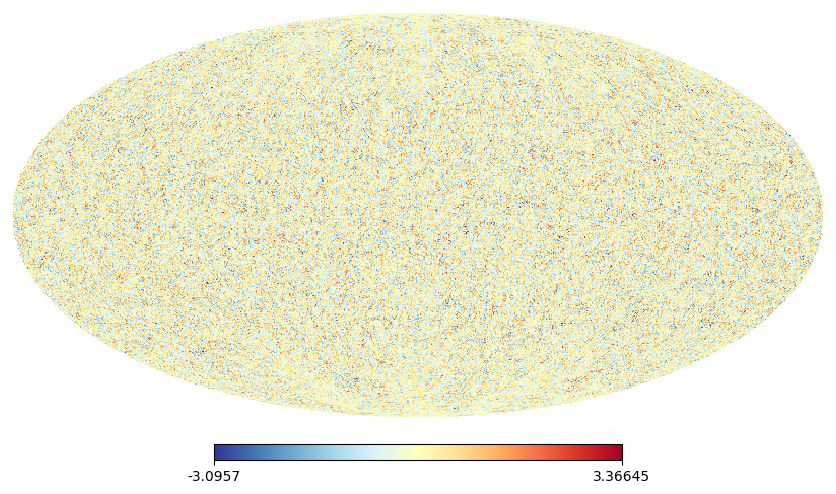

In [84]:
alms = hp.map2alm(TQU_map)
fl, filtered_alms = filter_alms(alms)
filtered_map = hp.alm2map(filtered_alms, nside)
hp.mollview(filtered_map[1], cmap="RdYlBu_r", title="")

We can visualize this large scale power loss from the power spectra.

(2.0, 256.0)

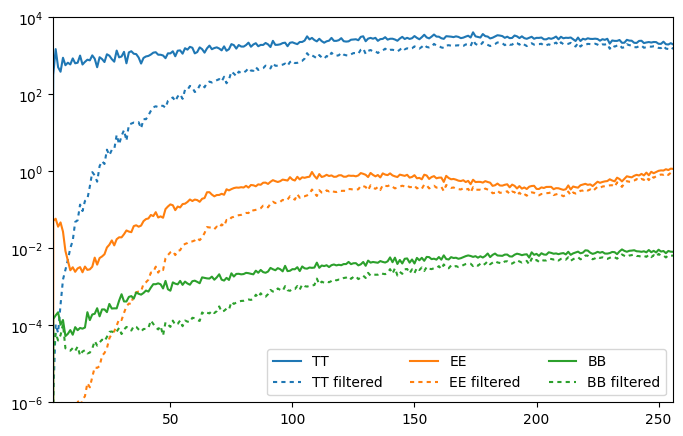

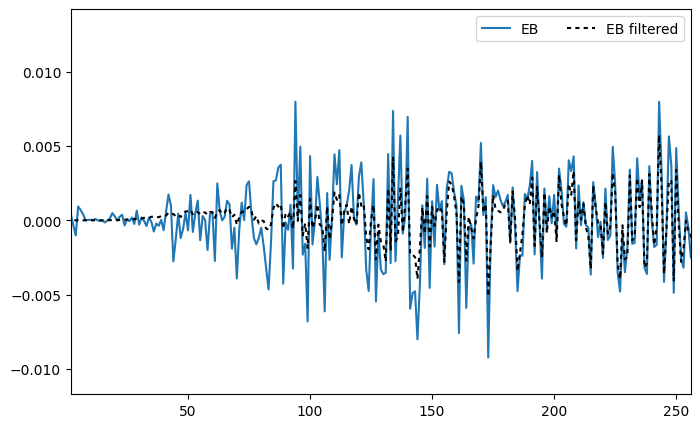

In [85]:
cl = hp.alm2cl(hp.map2alm(TQU_map))
cl_filt = hp.alm2cl(hp.map2alm(filtered_map))

import matplotlib.pyplot as plt
l = np.arange(cl[0].size)
fac = l * (l + 1) / (2 * np.pi)
plt.figure(figsize=(8, 5))
l, = plt.plot(cl[0]*fac, label="TT")
plt.plot(cl_filt[0]*fac, label="TT filtered", color=l.get_color(), ls=(0, (2, 2)))
l, = plt.plot(cl[1]*fac, label="EE")
plt.plot(cl_filt[1]*fac, label="EE filtered", color=l.get_color(), ls=(0, (2, 2)))
l, = plt.plot(cl[2]*fac, label="BB")
plt.plot(cl_filt[2]*fac, label="BB filtered", color=l.get_color(), ls=(0, (2, 2)))
plt.legend(ncol=3)
plt.yscale("log")
plt.ylim(1e-6, 1e4)
plt.xlim(2, 2*nside)

plt.figure(figsize=(8, 5))
l, = plt.plot(cl[4]*fac, label="EB")
plt.plot(cl_filt[4]*fac, label="EB filtered", color="k", ls=(0, (2, 2)))
plt.legend(ncol=2)
plt.xlim(2, 2*nside)

Below we use the 2-pt transfer function expression derived above to compute analytically the TF corresponding to our filtering.

In [144]:
fpairs = ["TT", "TE", "TB", "ET", "EE", "EB", "BT", "BE", "BB"]
tf = {}
for fp1 in fpairs:
    for fp2 in fpairs:
        X, Y = fp1[0], fp1[1]
        W, Z = fp2[0], fp2[1]
        fXW = fl["TEB".index(X), "TEB".index(W)]
        fYZ = fl["TEB".index(Y), "TEB".index(Z)]
        t_WZ_to_XY = hp.alm2cl(fXW.astype(np.complex128), fYZ.astype(np.complex128))
        tf[f"{W}{Z} to {X}{Y}"] = t_WZ_to_XY

We plot below the polarization panels of this transfer function.

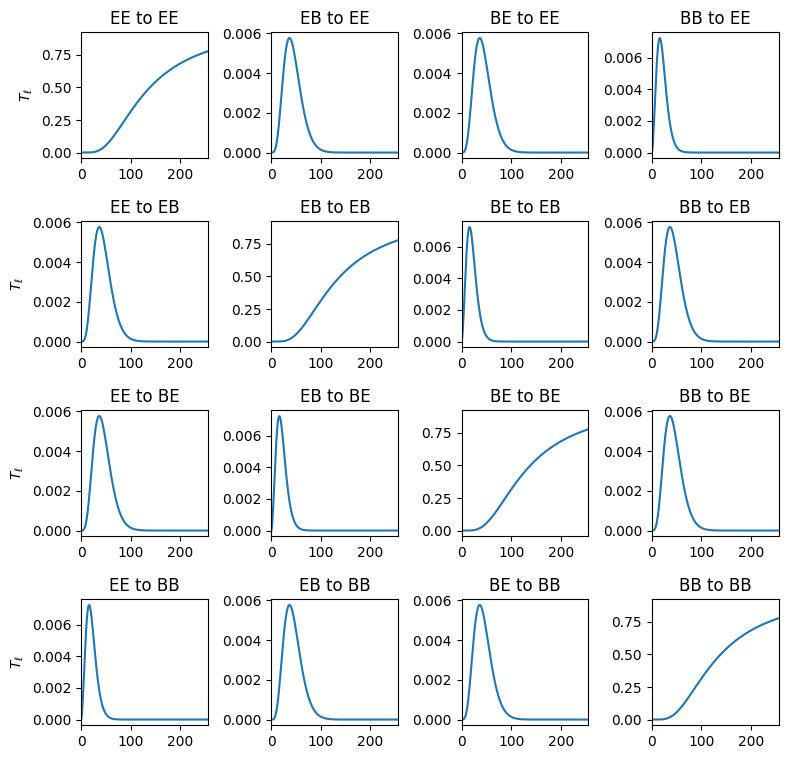

In [145]:
plt.figure(figsize=(9, 9))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
for i, fp1 in enumerate(["EE", "EB", "BE", "BB"]):
    for j, fp2 in enumerate(["EE", "EB", "BE", "BB"]):
        ax = plt.subplot(grid[i, j])
        key = f"{fp2} to {fp1}"
        plt.plot(np.arange(len(tf[key])), tf[key])
        plt.title(key)
        plt.xlim(0, 2*nside)
        if i == len(fpairs) - 1:
            plt.xlabel(r"$\ell$")
        if j == 0:
            plt.ylabel(r"$T_{\ell}$")

Below we generate some pureT/E/B simulations to get a sim-based estimate of the transfer function and compare it with the analytical expression from our toy-model filtering. These simulations will also be useful later to build a sim-based estimate of the covariance filtering correction.

In [141]:
# Compute transfer function with simulations
types = ["pureT", "pureE", "pureB"]
iStart, iStop = 0, 49
cl_PL = 1 / (ell + 10)**2

cls_mat = []
clsf_mat = []
for iii in range(iStart, iStop+1):
    alm = hp.synalm(cl_PL, lmax=3*nside-1)

    # maps is (pureT/E/B, I/Q/U, pixel)
    # maps = np.zeros((3, 3, hp.nside2npix(nside)))
    # alms_array is (pureT/E/B, T/E/B, lm)
    alms_array = np.zeros((3, 3, hp.Alm.getsize(3*nside-1)), dtype=np.complex128)
    falms_array = np.zeros_like(alms_array)
    for i, type in enumerate(types):
        alms = np.array([
            alm if t == type else np.zeros_like(alm) for t in types
        ])
        falms = filter_alms(alms)[1]
        alms_array[i] = alms
        falms_array[i] = falms
    
    cl_array = np.zeros((9, 9, 3*nside))
    clf_array = np.zeros((9, 9, 3*nside))
    idx = 0

    cls = {}
    clfs = {}
    for i1, type1 in enumerate(types):
        for i2, type2 in enumerate(types):
            # 0   1   2   3   4   5
            # TT, EE, BB, TE, EB, TB
            cl = hp.alm2cl(
                alms_array[i1],
                alms_array[i2],
                lmax=3*nside-1
            )
            # TT, EE, BB, TE, EB, TB
            clf = hp.alm2cl(
                falms_array[i1],
                falms_array[i2],
                lmax=3*nside-1
            )
            cls[type1, type2] = cl
            clfs[type1, type2] = clf
    
    for idx, (type1, type2) in enumerate(product(types, repeat=2)):
        cl_array[idx] = np.array([
            cls[type1, type2][0],
            cls[type1, type2][3],
            cls[type1, type2][5],
            cls[type2, type1][3],
            cls[type2, type1][5],
            cls[type1, type2][1],
            cls[type1, type2][4],
            cls[type2, type1][4],
            cls[type1, type2][2]
        ])
        clf_array[idx] = np.array([
            clfs[type1, type2][0],
            clfs[type1, type2][3],
            clfs[type1, type2][5],
            clfs[type2, type1][3],
            clfs[type2, type1][5],
            clfs[type1, type2][1],
            clfs[type1, type2][4],
            clfs[type2, type1][4],
            clfs[type1, type2][2]
        ])
    cls_mat.append(cl_array)
    clsf_mat.append(clf_array)
cls_mat = np.array(cls_mat)
clsf_mat = np.array(clsf_mat)

In [142]:
cls_mat_avg = np.mean(cls_mat, axis=0)
clsf_mat_avg = np.mean(clsf_mat, axis=0)

cct_inv = np.transpose(
    np.linalg.inv(
        np.transpose(
            np.einsum(
                'jil,jkl->ikl',
                cls_mat_avg,
                cls_mat_avg
            ),
            axes=[2, 0, 1]
        )
    ), axes=[1, 2, 0]
)

tf_sim = np.einsum(
    'ijl,jkl->kil',
    cct_inv,
    np.einsum(
        'jil,jkl->ikl',
        cls_mat_avg,
        clsf_mat_avg
    )
)

tferr = np.std(
    np.array([
        np.einsum(
            'ijl,jkl->kil',
            cct_inv,
            np.einsum(
                'jil,jkl->ikl',
                cls_mat_avg,
                clf
            )
        )
        for clf in clsf_mat
        ]),
    axis=0
)

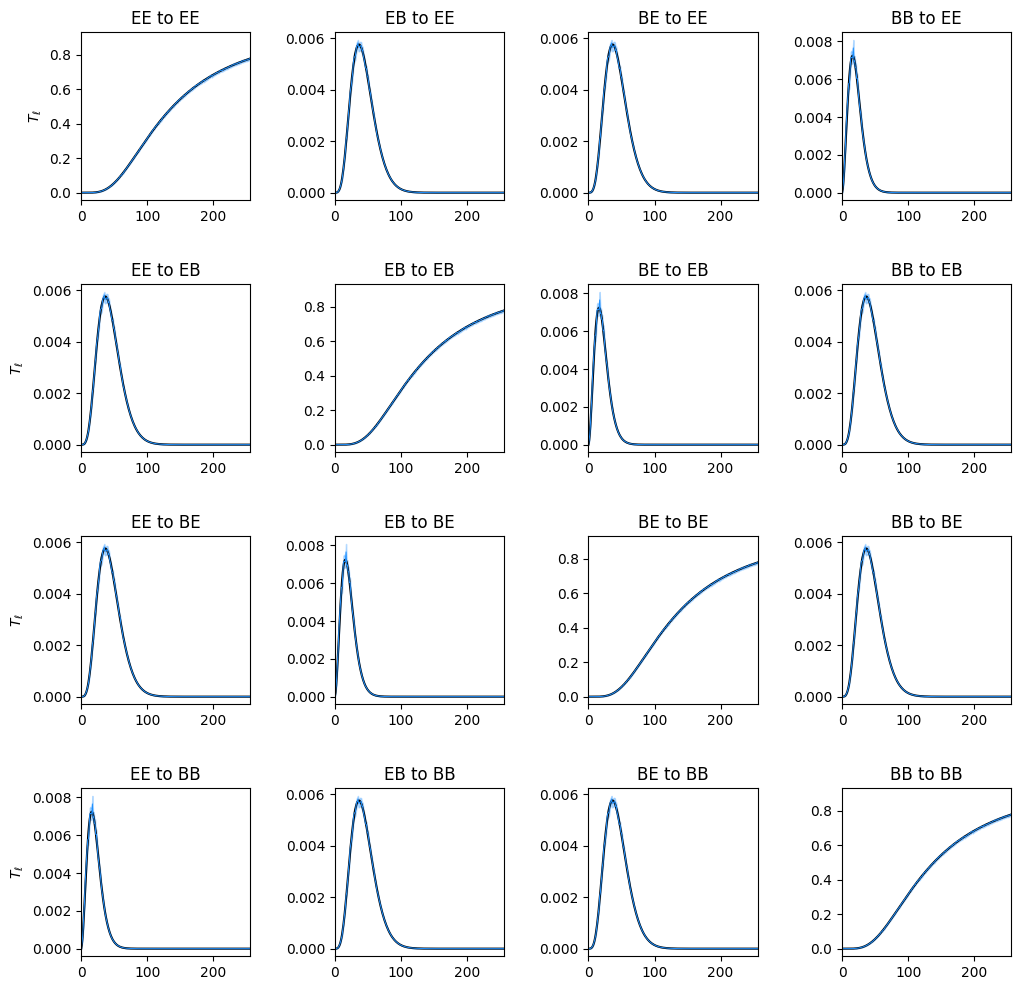

In [152]:
plt.figure(figsize=(12, 12))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
for i, fp1 in enumerate(["EE", "EB", "BE", "BB"]):
    for j, fp2 in enumerate(["EE", "EB", "BE", "BB"]):
        ax = plt.subplot(grid[i, j])
        key = f"{fp2} to {fp1}"
        plt.plot(np.arange(len(tf[key])), tf[key], color="k")
        plt.plot(np.arange(len(tf[key])), tf_sim[-4+i, -4+j], color="DodgerBlue", lw=0.7)
        plt.fill_between(
            np.arange(len(tf[key])),
            tf_sim[-4+i, -4+j] - tferr[-4+i, -4+j]/np.sqrt(iStop-iStart+1),
            tf_sim[-4+i, -4+j] + tferr[-4+i, -4+j]/np.sqrt(iStop-iStart+1),
            color="DodgerBlue",
            alpha=0.3
        )
        plt.title(key)
        plt.xlim(0, 2*nside)
        if i == len(fpairs) - 1:
            plt.xlabel(r"$\ell$")
        if j == 0:
            plt.ylabel(r"$T_{\ell}$")

The question we should now answer is: how to propagate the effect of filtering to the covariance ?
On a single field, one could write
$$
    \hat{C}_\ell = \frac{1}{2\ell + 1}\sum_m f_{\ell m}^2 a_{\ell m}a_{\ell m}^\star
$$
with
$$
    \langle \hat{C}_\ell \rangle = \frac{1}{2\ell + 1}\sum_m f_{\ell m}^2 C_\ell = T_\ell^{\rm 2pt} C_\ell = \tilde{C}_\ell
$$
Covariance is then expressed
$$
    \mathrm{cov}(\hat{C}_\ell) = \frac{2\tilde{C}_\ell^2}{2\ell + 1} \frac{T_\ell^{\rm 4pt}}{{T_\ell^{\rm 2pt}}^2} = \frac{2C_\ell^2}{2\ell + 1}T_\ell^{\rm 4pt}
$$
where we defined
$$
    T_\ell^{\rm 4pt} = \frac{1}{2\ell + 1}\sum_m f_{\ell m}^4
$$

Proper derivation of the impact on the covariance is more tedious (and I think untractable)

$$
\mathrm{cov}(\tilde{C}_\ell^{XY}, \tilde{C}_{\ell'}^{WZ}) = \frac{1}{2\ell+1}\frac{1}{2\ell'+1}\sum_{mm'}\sum_{xywz}f_{\ell m}^{Xx}{f_{\ell m}^{Yy}}^*f_{\ell'm'}^{Ww}{f_{\ell'm'}^{Zz}}^* \delta_{\ell\ell'}(\langle a_{\ell m}^x a_{\ell' m'}^w\rangle\langle a_{\ell m}^{y*}a_{\ell'm'}^{z*} \rangle + \langle a_{\ell m}^xa_{\ell'm'}^{z*} \rangle \langle a_{\ell m}^{y*}a_{\ell'm'}^{w} \rangle)
$$

Below we plot the 4pt transfer function $T_\ell^{\rm 4pt}$ estimated from the $f_{\ell m}$ and compare it to the 2pt transfer function.

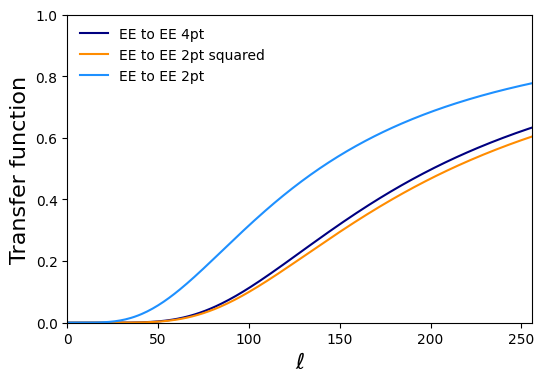

In [203]:
t4_EEEE_EEEE = hp.alm2cl(
    (fl[1, 1] ** 2).astype(np.complex128),
    (fl[1, 1] ** 2).astype(np.complex128),
)
t4_BBBB_BBBB = hp.alm2cl(
    (fl[2, 2] ** 2).astype(np.complex128),
    (fl[2, 2] ** 2).astype(np.complex128),
)
plt.figure(figsize=(6, 4))
plt.plot(t4_EEEE_EEEE, label="EE to EE 4pt", color="navy")
plt.plot(tf["EE to EE"] ** 2, label="EE to EE 2pt squared", color="darkorange")
plt.plot(tf["EE to EE"], label="EE to EE 2pt", color="DodgerBlue")

plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"Transfer function", fontsize=16)

plt.ylim(0, 1)
plt.xlim(0, 2 * nside)
plt.legend(frameon=False);

Below we simulate CMB skies to build an sim-based estimate of covariances.

In [195]:
iStart, iStop = 0, 699
cls = []
clsf = []
clsfd = []

tf_batched = np.moveaxis(tf_sim, 2, 0)
tf_batched = tf_batched[1:, :, :]
tf_batched_inv = np.linalg.inv(tf_batched)
tf_sim_inv = np.moveaxis(tf_batched_inv, 0, 2)

for iii in range(iStart, iStop+1):
    # TQU = hp.synfast(
    #     [theory_cells["TT"], theory_cells["TE"], theory_cells["EE"], theory_cells["BB"]],
    #     nside=nside,
    #     fwhm=fwhm_rad
    # )
    # alms = hp.map2alm(TQU)
    alms = hp.synalm(
        [theory_cells["TT"], theory_cells["TE"], theory_cells["EE"], theory_cells["BB"]],
        lmax=3*nside-1
    )
    alms = np.array([hp.almxfl(alm, bl) for alm in alms])
    fl, filtered_alms = filter_alms(alms)
    #TQU_f = hp.alm2map(filtered_alms, nside)
    #cl = hp.alm2cl(hp.map2alm(TQU))
    #clf = hp.alm2cl(hp.map2alm(TQU_f))
    # 0   1   2   3   4   5
    # TT, EE, BB, TE, EB, TB
    cl = hp.alm2cl(alms)
    clf = hp.alm2cl(filtered_alms)

    clf_vec = np.array([
        clf[0],
        clf[3],
        clf[5],
        clf[3],
        clf[5],
        clf[1],
        clf[4],
        clf[4],
        clf[2]
    ])
    clf_vec_dec = np.einsum(
        "ijl,jl->il",
        tf_sim_inv,
        clf_vec[:, 1:]
    )

    
    cls.append(cl)
    clsf.append(clf)
    clsfd.append(np.array([
        clf_vec_dec[0],
        clf_vec_dec[-4],
        clf_vec_dec[-1],
        clf_vec_dec[1],
        clf_vec_dec[-3],
        clf_vec_dec[2]
    ]))

In [196]:
cls = np.array(cls)
clsf = np.array(clsf)
clsfd = np.array(clsfd)

knoxEE_filtered = np.mean(clsf[:, 1, :], axis=0)**2 * 2 / (2 * np.arange(clsf.shape[2]))
knoxBB_filtered = np.mean(clsf[:, 2, :], axis=0)**2 * 2 / (2 * np.arange(clsf.shape[2]))

/tmp/ipykernel_557381/1670561263.py:5: RuntimeWarning: invalid value encountered in divide
  knoxEE_filtered = np.mean(clsf[:, 1, :], axis=0)**2 * 2 / (2 * np.arange(clsf.shape[2]))
/tmp/ipykernel_557381/1670561263.py:6: RuntimeWarning: invalid value encountered in divide
  knoxBB_filtered = np.mean(clsf[:, 2, :], axis=0)**2 * 2 / (2 * np.arange(clsf.shape[2]))


In [197]:
# cl [TT EE BB TE EB TB]
NcovEE = np.cov(cls[:, 1], cls[:, 1], rowvar=False)[:cls.shape[-1], :cls.shape[-1]]
NcovEEf = np.cov(clsf[:, 1], clsf[:, 1], rowvar=False)[:clsf.shape[-1], :clsf.shape[-1]]
NcovEEfd = np.cov(clsfd[:, 1], clsfd[:, 1], rowvar=False)[:clsfd.shape[-1], :clsfd.shape[-1]]

In [198]:
NcovBB = np.cov(cls[:, 2], cls[:, 2], rowvar=False)[:cls.shape[-1], :cls.shape[-1]]
NcovBBf = np.cov(clsf[:, 2], clsf[:, 2], rowvar=False)[:clsf.shape[-1], :clsf.shape[-1]]
NcovBBfd = np.cov(clsfd[:, 2], clsfd[:, 2], rowvar=False)[:clsfd.shape[-1], :clsfd.shape[-1]]

(384, 384)


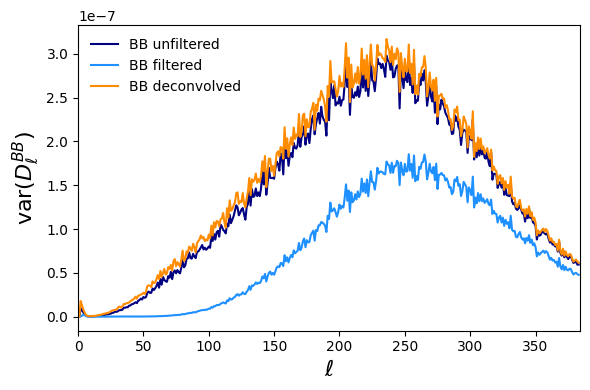

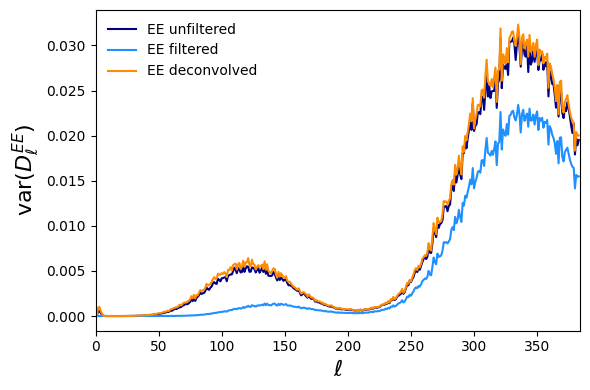

In [199]:
plt.figure(figsize=(6, 4))
ell_plot = np.arange(NcovBB.shape[0])
fac = ell_plot * (ell_plot + 1) / (2 * np.pi)
print(NcovBB.shape)
plt.plot(
    ell_plot, np.diag(NcovBB) * fac**2, label="BB unfiltered", color="navy"
)
plt.plot(
    ell_plot,
    np.diag(NcovBBf) * fac**2,
    label="BB filtered",
    color="DodgerBlue",
)
plt.plot(
    ell_plot[1:],
    np.diag(NcovBBfd) * fac[1:]**2,
    label="BB deconvolved",
    color="darkorange"
)
plt.xlim(0, 3 * nside)
plt.legend(frameon=False)
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"$\mathrm{var}(D_\ell^{BB})$", fontsize=16)
plt.tight_layout()


plt.figure(figsize=(6, 4))
plt.plot(
    ell_plot, np.diag(NcovEE) * fac**2, label="EE unfiltered", color="navy"
)
plt.plot(
    ell_plot,
    np.diag(NcovEEf) * fac**2,
    label="EE filtered",
    color="DodgerBlue",
)
plt.plot(
    ell_plot[1:],
    np.diag(NcovEEfd) * fac[1:]**2,
    label="EE deconvolved",
    color="darkorange"
)
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"$\mathrm{var}(D_\ell^{EE})$", fontsize=16)
plt.xlim(0, 3 * nside)
plt.legend(frameon=False)
plt.tight_layout()

/tmp/ipykernel_557381/964742148.py:7: RuntimeWarning: invalid value encountered in divide
  NcovEEf.diagonal() / knoxEE_filtered,
/tmp/ipykernel_557381/964742148.py:21: RuntimeWarning: invalid value encountered in divide
  NcovEEfd.diagonal() / NcovEE.diagonal()[1:],
/tmp/ipykernel_557381/964742148.py:30: RuntimeWarning: invalid value encountered in divide
  t4_EEEE_EEEE / tf["EE to EE"] ** 2,
/tmp/ipykernel_557381/964742148.py:49: RuntimeWarning: invalid value encountered in divide
  mu, edges, _ = binned_statistic(ell_plot[1:], NcovEEfd.diagonal() / NcovEE.diagonal()[1:], statistic="mean", bins=np.arange(2, 3*nside, bin_size))
/tmp/ipykernel_557381/964742148.py:50: RuntimeWarning: invalid value encountered in divide
  sig, edges, _ = binned_statistic(ell_plot[1:], NcovEEfd.diagonal() / NcovEE.diagonal()[1:], statistic="std", bins=np.arange(2, 3*nside, bin_size))
/tmp/ipykernel_557381/964742148.py:66: RuntimeWarning: invalid value encountered in divide
  NcovBBf.diagonal() / knoxBB_fi

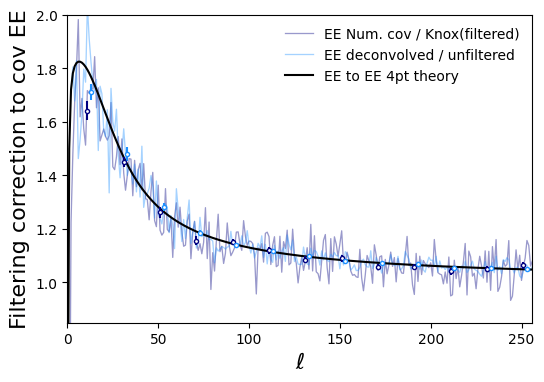

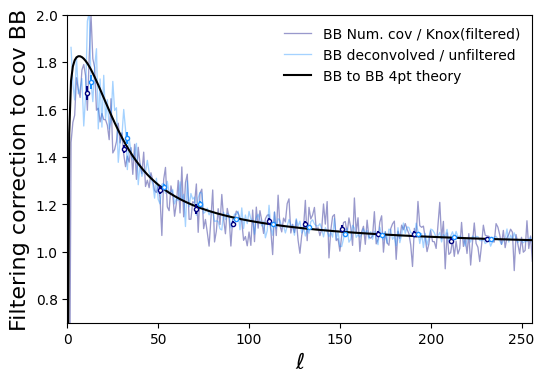

In [202]:
from scipy.stats import binned_statistic
bin_size=20

plt.figure(figsize=(6, 4))
ratio_EE_th = np.where(
    knoxEE_filtered != 0,
    NcovEEf.diagonal() / knoxEE_filtered,
    0,
)
plt.plot(
    ell_plot,
    ratio_EE_th,
    label="EE Num. cov / Knox(filtered)",
    color="navy",
    lw=0.95,
    alpha=0.4
)

plt.plot(
    ell_plot[1:],
    NcovEEfd.diagonal() / NcovEE.diagonal()[1:],
    label="EE deconvolved / unfiltered",
    color="DodgerBlue",
    lw=0.95,
    alpha=0.4
)

ratio_EE = np.where(
    tf["EE to EE"] != 0,
    t4_EEEE_EEEE / tf["EE to EE"] ** 2,
    0,
)
plt.plot(
    ell_plot,
    ratio_EE,
    label="EE to EE 4pt theory",
    color="k",
)
mu, edges, _ = binned_statistic(ell_plot, ratio_EE_th, statistic="mean", bins=np.arange(2, 3*nside, bin_size))
sig, edges, _ = binned_statistic(ell_plot, ratio_EE_th, statistic="std", bins=np.arange(2, 3*nside, bin_size))

plt.errorbar(
    (edges[:-1] + edges[1:]) / 2-1,
    mu,
    yerr=sig/np.sqrt(bin_size),
    color="navy" , zorder=5, ls="None", marker=".", markerfacecolor="white",

)
mu, edges, _ = binned_statistic(ell_plot[1:], NcovEEfd.diagonal() / NcovEE.diagonal()[1:], statistic="mean", bins=np.arange(2, 3*nside, bin_size))
sig, edges, _ = binned_statistic(ell_plot[1:], NcovEEfd.diagonal() / NcovEE.diagonal()[1:], statistic="std", bins=np.arange(2, 3*nside, bin_size))
plt.errorbar(
    (edges[:-1] + edges[1:]) / 2+1,
    mu,
    yerr=sig/np.sqrt(bin_size),
    color="DodgerBlue" , zorder=5, ls="None", marker=".", markerfacecolor="white",
)
plt.xlim(0, 2 * nside)
plt.ylim(0.85, 2.0)
plt.legend(frameon=False)
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"Filtering correction to cov EE", fontsize=16);

plt.figure(figsize=(6, 4))
ratio_BB_th = np.where(
    knoxBB_filtered != 0,
    NcovBBf.diagonal() / knoxBB_filtered,
    0,
)
plt.plot(
    ell_plot,
    ratio_BB_th,
    label="BB Num. cov / Knox(filtered)",
    color="navy",
    lw=0.95,
    alpha=0.4
)
plt.plot(
    ell_plot[1:],
    NcovBBfd.diagonal() / NcovBB.diagonal()[1:],
    label="BB deconvolved / unfiltered",
    color="DodgerBlue",
    lw=0.95,
    alpha=0.4
)
ratio_BB = np.where(
    tf["BB to BB"] != 0,
    t4_BBBB_BBBB / tf["BB to BB"] ** 2,
    0,
)
plt.plot(
    ell_plot,
    ratio_BB,
    label="BB to BB 4pt theory",
    color="k",
)
mu, edges, _ = binned_statistic(ell_plot, ratio_BB_th, statistic="mean", bins=np.arange(2, 2*nside, 20))
sig, edges, _ = binned_statistic(ell_plot, ratio_BB_th, statistic="std", bins=np.arange(2, 2*nside, 20))
plt.errorbar(
    (edges[:-1] + edges[1:]) / 2-1,
    mu,
    yerr=sig/np.sqrt(20),
    color="navy" , zorder=5, ls="None", marker=".", markerfacecolor="white",
)
mu, edges, _ = binned_statistic(ell_plot[1:], NcovBBfd.diagonal() / NcovBB.diagonal()[1:], statistic="mean", bins=np.arange(2, 2*nside, 20))
sig, edges, _ = binned_statistic(ell_plot[1:], NcovBBfd.diagonal() / NcovBB.diagonal()[1:], statistic="std", bins=np.arange(2, 2*nside, 20))
plt.errorbar(
    (edges[:-1] + edges[1:]) / 2+1,
    mu,
    yerr=sig/np.sqrt(20),
    color="DodgerBlue" , zorder=5, ls="None", marker=".", markerfacecolor="white",
)
plt.xlim(0, 2 * nside)
plt.ylim(0.7, 2.0)
plt.legend(frameon=False)
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"Filtering correction to cov BB", fontsize=16);

In [111]:
# On a masked sky
def mask_from_disc(template, ycenter, xcenter, radius, n_repeat=1):
    mask = template.copy()
    mask[:] = 0.
    mask[
        hp.query_disc(
            nside,
            hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter)), radius=np.deg2rad(radius)
        )
    ] = 1.
    if n_repeat > 1:
        for i in range(1, n_repeat+1):
            mask[
                hp.query_disc(
                    nside,
                    hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter + i * radius/4)), radius=np.deg2rad(radius)
                )
            ] = 1.
            mask[
                hp.query_disc(
                    nside,
                    hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter - i * radius/4)), radius=np.deg2rad(radius)
                )
            ] = 1.
    return mask



In [115]:
disk_mask = mask_from_disc(TQU_map[1], 120, 0, 20, 11)
import pymaster as nmt
disk_mask_apo = nmt.mask_apodization(disk_mask, aposize=10, apotype="C1")
b = nmt.NmtBin.from_nside_linear(nside, 10)
wsp = nmt.NmtWorkspace(nmt.NmtField(disk_mask_apo, None, spin=2), nmt.NmtField(disk_mask_apo, None, spin=2), b)

In [117]:
iStart, iStop = 0, 99
cl_coupled = []
cl_decoupled = []
for iii in range(iStart, iStop+1):
    print(f"Iteration {iii+1}/{iStop+1}")
    TQU = hp.synfast(
        [theory_cells["TT"], theory_cells["TE"], theory_cells["EE"], theory_cells["BB"]],
        nside=nside,
        fwhm=fwhm_rad
    )
    alms = hp.map2alm(TQU)
    pB = alms.copy()
    pB[0:2, :] = 0.

    fl, filtered_alms = filter_alms(alms)
    fl, filtered_pB = filter_alms(pB)
    TQU_f = hp.alm2map(filtered_alms, nside)
    TQU_pB_f = hp.alm2map(filtered_pB, nside)
    TQU_pB = hp.alm2map(pB, nside)

    fields = {
        "default": nmt.NmtField(disk_mask_apo, TQU[1:]),
        "default_filtered": nmt.NmtField(disk_mask_apo, TQU_f[1:]),
        "pureB": nmt.NmtField(disk_mask_apo, TQU_pB[1:]),
        "pureB_filtered": nmt.NmtField(disk_mask_apo, TQU_pB_f[1:])
    }
    pcls = {
        k: nmt.compute_coupled_cell(fields[k], fields[k])
        for k in fields
    }
    cls = {
        k: wsp.decouple_cell(pcls[k])
        for k in pcls
    }
    cl_coupled.append(pcls)
    cl_decoupled.append(cls)
    # cl = hp.alm2cl(hp.map2alm(TQU))
    # clf = hp.alm2cl(hp.map2alm(TQU_f))
    # cls.append(cl)
    # clsf.append(clf)

Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [ ]:
num_cov_EE_decoupled = {
    k: np.std([cl_decoupled[i][k][0] for i in range(iStart, iStop+1)], axis=0)**2
    for k in cl_decoupled[0]
}
num_cov_EE_coupled = {
    k: np.std([cl_coupled[i][k][0] for i in range(iStart, iStop+1)], axis=0)**2
    for k in cl_coupled[0]
}

/tmp/ipykernel_821237/1770937393.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(num_cov_EE_coupled["default_filtered"])), num_cov_EE_coupled["default_filtered"]/num_cov_EE_coupled["default"], label="EE to EE coupled filtered")
/tmp/ipykernel_821237/1770937393.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.arange(len(num_cov_EE_coupled["pureB_filtered"])), num_cov_EE_coupled["pureB_filtered"]/num_cov_EE_coupled["pureB"], label="BB to BB coupled filtered")


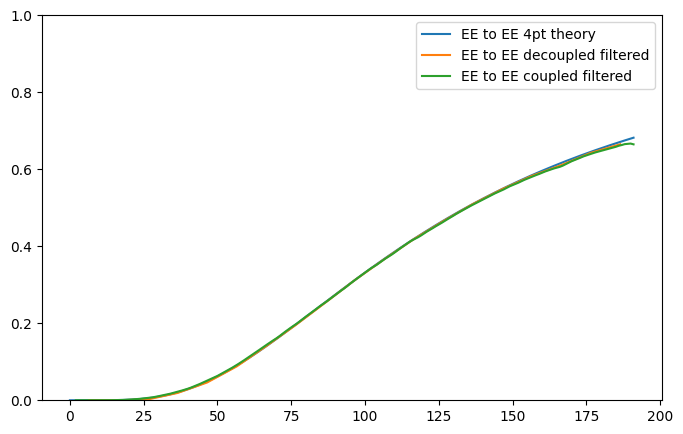

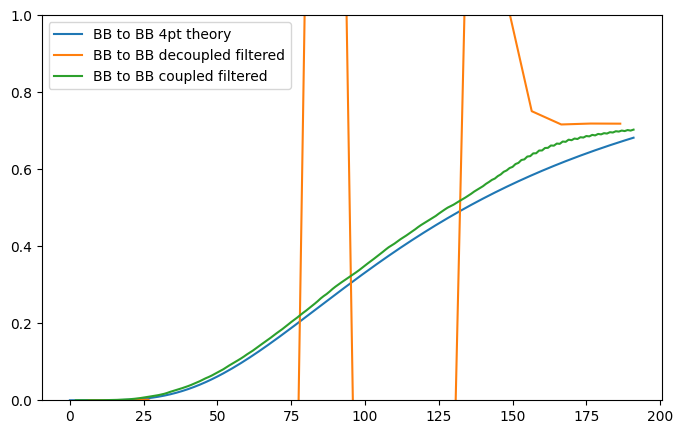

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(t4_EEEE_EEEE**0.505, label="EE to EE 4pt theory")
plt.plot(b.get_effective_ells(), num_cov_EE_decoupled["default_filtered"]/num_cov_EE_decoupled["default"], label="EE to EE decoupled filtered")
plt.plot(np.arange(len(num_cov_EE_coupled["default_filtered"])), num_cov_EE_coupled["default_filtered"]/num_cov_EE_coupled["default"], label="EE to EE coupled filtered")
plt.ylim(0, 1)
plt.legend()

plt.figure(figsize=(8, 5))
plt.plot(t4_BBBB_BBBB**0.505, label="BB to BB 4pt theory")
plt.plot(b.get_effective_ells(), num_cov_EE_decoupled["pureB_filtered"]/num_cov_EE_decoupled["pureB"], label="BB to BB decoupled filtered")
plt.plot(np.arange(len(num_cov_EE_coupled["pureB_filtered"])), num_cov_EE_coupled["pureB_filtered"]/num_cov_EE_coupled["pureB"], label="BB to BB coupled filtered")
plt.ylim(0, 1)
plt.legend()



(2, 256)

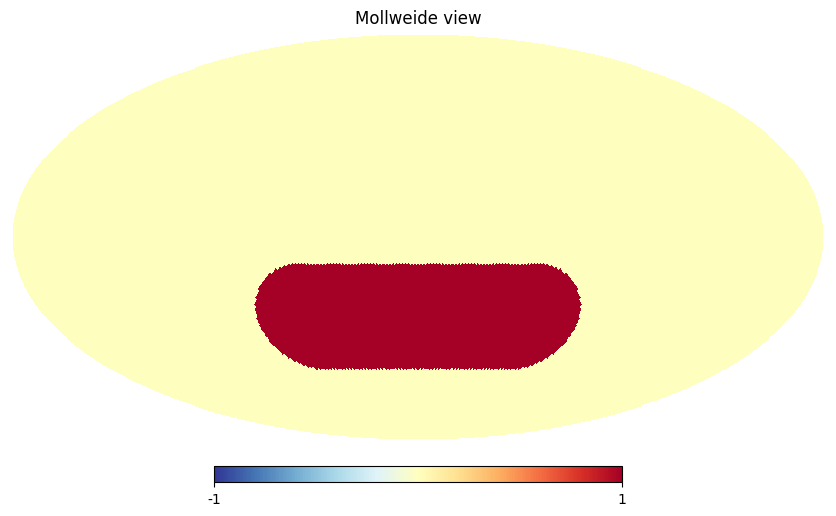

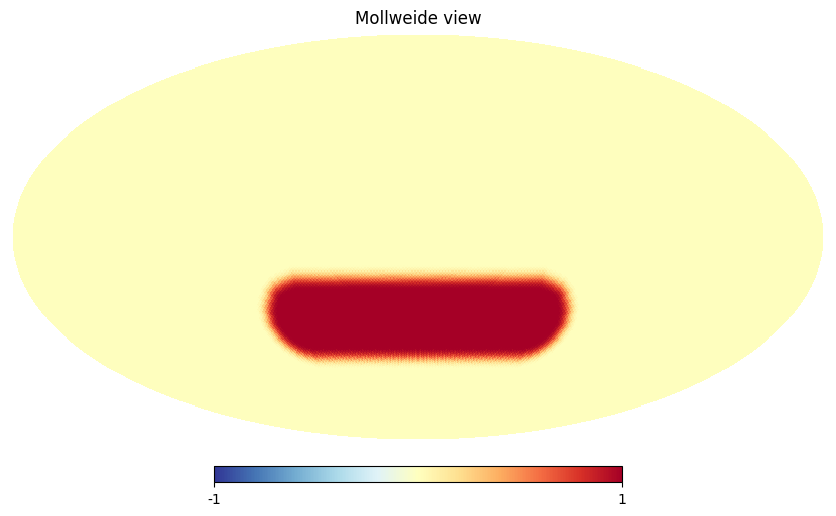

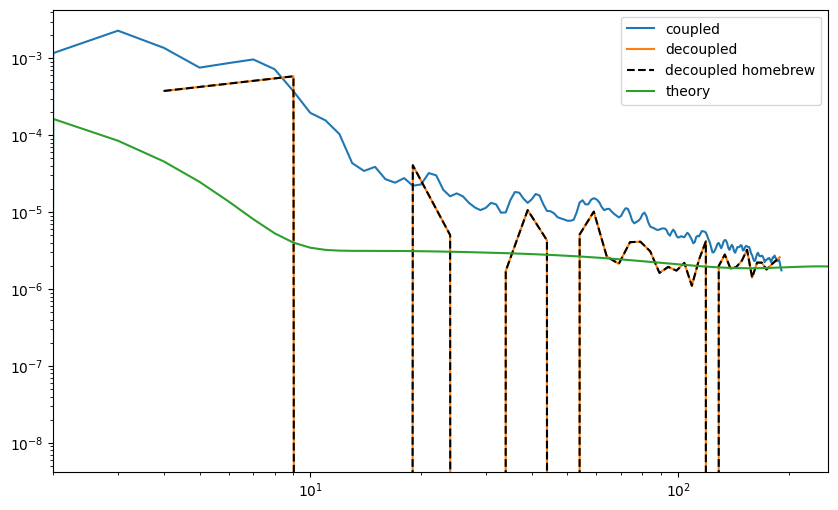

In [21]:
import healpy as hp
import matplotlib.pyplot as plt

def mask_from_disc(template, ycenter, xcenter, radius, n_repeat=1):
    mask = template.copy()
    mask[:] = 0.
    mask[
        hp.query_disc(
            nside,
            hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter)), radius=np.deg2rad(radius)
        )
    ] = 1.
    if n_repeat > 1:
        for i in range(1, n_repeat+1):
            mask[
                hp.query_disc(
                    nside,
                    hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter + i * radius/4)), radius=np.deg2rad(radius)
                )
            ] = 1.
            mask[
                hp.query_disc(
                    nside,
                    hp.ang2vec(np.deg2rad(ycenter), np.deg2rad(xcenter - i * radius/4)), radius=np.deg2rad(radius)
                )
            ] = 1.
    return mask

mock = hp.synfast(
    [theory_cells["TT"], theory_cells["TE"], theory_cells["EE"], theory_cells["BB"]],
    nside=nside,
)
disk_mask = mask_from_disc(mock[1], 120, 0, 20, 11)
hp.mollview(disk_mask, min=-1, max=1, cmap="RdYlBu_r")
import pymaster as nmt
disk_mask_apo = nmt.mask_apodization(disk_mask, aposize=10, apotype="C1")
hp.mollview(disk_mask_apo, min=-1, max=1, cmap="RdYlBu_r")
f2 = nmt.NmtField(disk_mask_apo, mock[1:])
cl = nmt.compute_coupled_cell(f2, f2)
b = nmt.NmtBin.from_nside_linear(nside, 5)
w = nmt.NmtWorkspace(f2, f2, bins=b)
w.compute_coupling_matrix(f2, f2, b)
mcm = np.transpose(w.get_coupling_matrix().reshape((3*nside, 4, 3*nside, 4)), axes=[1, 0, 3, 2])
binner = np.array([b.bin_cell(np.array([cl]))[0]
                       for cl in np.eye(3*nside)]).T
mcm = np.einsum("ij,kjlm->kilm", binner, mcm)
bmcm = np.transpose(
    np.array([
        np.sum(mcm[:, :, :, b.get_ell_list(i)],
               axis=-1)
               for i in range(b.get_n_bands())
    ]), axes=[1, 2, 3, 0]
)
ibmcm = np.linalg.inv(
    bmcm.reshape([4*b.get_n_bands(), 4*b.get_n_bands()])
)
ibmcm = ibmcm.reshape([4, b.get_n_bands(), 4, b.get_n_bands()])
cb_home = np.einsum("ijkl,kl->ij", ibmcm, b.bin_cell(cl))
cb = w.decouple_cell(cl)

plt.figure(figsize=(10, 6))
plt.plot(cl[-1]/np.mean(disk_mask_apo**2),label="coupled")
plt.plot(b.get_effective_ells(), cb[-1], label="decoupled")
plt.plot(b.get_effective_ells(), cb_home[-1], label="decoupled homebrew", ls="--", color="k")
plt.plot(theory_cells["BB"], label="theory")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlim(2, 256)
# plt.ylim(3e-5, 1e-3)

